# Simulacion - 75.26
## TP1 - Xorshift RNGs
### Grupo 4 
### Integrantes: Joaquín Rivero, Juan Pablo Aschieri, Diego Civini, Francisco Rovira Rossel

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi, e, log
from scipy.stats import kstest, shapiro
import time

## Ejercicio 1

Hacemos una clase `Xorshift_generator` que dada una semilla devuelve un generador de numeros aleatorios de 32 bits realizando operaciones logicas de shifteo y xor. Los valores usados para la cantidad de shifteos fueron sacados del paper.

In [2]:
class Xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349

    def rand(self):
        tmp = ( self.x^ (self.x <<13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

In [3]:
class Uniform_generator:
    def __init__(self, seed, scale= 1, displacement= 0):
        self.xorshift_genertor = Xorshift_generator(seed)
        self.scale = scale
        self.displacement = displacement

    def rand(self):
        n = self.xorshift_genertor.rand() / ((2**32)-1)
        return n * self.scale + self.displacement
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

Obtenemos un generador con una semilla y obtenemos 100000 numeros para analizar los resultados.

Graficamos los numeros en un histograma para obtener una representacion visual aproximada de su distribucion. Como buscamos numeros aleatorios entre 0 y 2^32 -1 deberia ser un grafico similar a una distribucion uniforme entre 0 y 2^32 -1

In [4]:
generator = Xorshift_generator(123456789)

In [5]:
def get_random_and_plot(generator, amount, bins):

    rand_numbers = generator.get_n_rand(amount)

    plt.hist(rand_numbers, bins = bins)
    plt.show()
    return rand_numbers

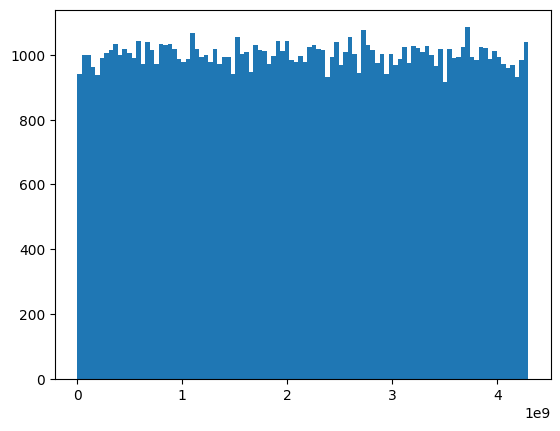

In [9]:
rand_numbers = get_random_and_plot(generator, 100000, 100)

Si bien no es perfecto se puede ver como aproximadamente los distintos box tienen la misma cantidad de ocurrencias, haciendo que el grafico dado se parezca a una meseta, que es el grafico que deberia tener una uniforme.

Si queremos obtener numero aleatorios entre 0 y 1 utilizando el xorshift generator, basta con generar un numero aleatorio de la misma manera y luego normalizarlo. Para ello dividimos al numero por el mayor valor posible, 2^32 -1. De esta manera obtenemos un numero aleatorio entre 0 y 1 con el nuevo generador uniform_generator

In [6]:
generator_u = Uniform_generator(5568782738)

De la misma forma graficamos un histograma para ver si la distribucion de los numeros se asemeja a una distribucion uniforme entre 0 y 1.

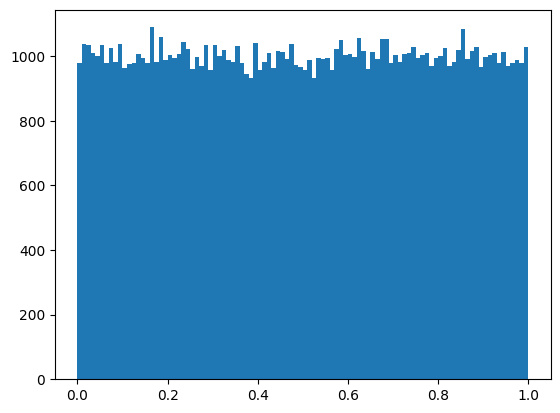

In [11]:
rand_numbers = get_random_and_plot(generator_u, 100000, 100)

De una forma similar, podemos ver a esta distribucion uniforme "de a pares", es decir, podemos graficar en el plano XY pares de números aleatorios generados.

In [12]:
pairs_of_rand_numbers_normalized = []
for i in range(50000):
    pairs_of_rand_numbers_normalized.append((generator_u.rand(), generator_u.rand()))

Ya obtenido el arreglo con las tuplas de numeros aleatorios, procedemos a graficarlos en un plano cartesiano. Si los números siguen una distribuicion uniforme entre 0 y 1, deberíamos ver que el gráfico se asemeja a un cuadrado de lado 1 cuyos vertices son (0,0), (0,1), (1,0), (1,1).

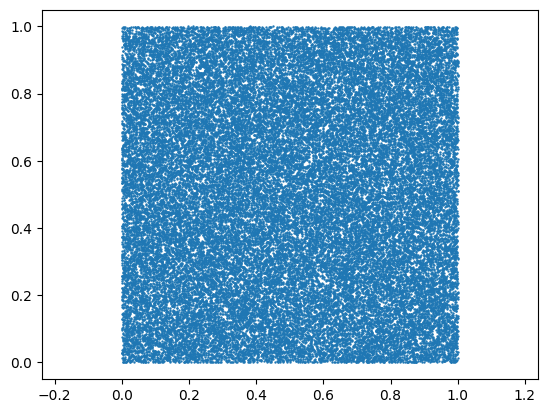

In [13]:
x = [p[0] for p in pairs_of_rand_numbers_normalized]
y = [p[1] for p in pairs_of_rand_numbers_normalized]
plt.scatter(x, y, s=0.5)
plt.axis('equal')
plt.show()

Visualmente se puede ver que, efectivamente, los puntos en conjunto forman un cuadrado y estan distribuidos uniformente sobre el grafico, lo cual tiene sentido ya que las coordenadas X e Y son independientes, entonces al tener una muestra de un tamaño considerable de tuplas de números aleatorios entre 0 y 1 (en este caso 50 mil tuplas), estos tienden a rellenar un cuadrado de lado 1. 

## Ejercicio 2

*Para los generadores implementados en el ejercicio 1:  
● Proponer, y realizar, al menos 3 tests para evaluar su comportamiento.  
● Evaluar e interpretar los resultados de cada test para distintos tamaños de muestras.*

### Test chi2


Si bien el test de la chi2 necesita que la distribución sea discreta, nosotros tenemos una distribución continua y uniforme. Esto presenta un problema. Para poder realizar este test, podemos discretizar la distribucion juntando valores de intervalos en bins. En este caso vamos a usar 100 bins.

Este test nos permite saber con un nivel de significación alfa (usaremos 0.05) si los valores que generamos NO tienen distribución uniforme. Para ello tomamos como hipótesis nula que la distribucion **es** uniforme en el intervalo correspondiente.  
Si podemos rechazar la hipotesis nula: afirmaremos que la distribución no es uniforme.  
En caso de no rechazar la hipótesis nula: no podemos afirmar que la distribución es uniforme.

Asumo como **H0** que la dist es uniforme. Este test NO SIRVE para decir si una dist es uniforme. Sirve para decir, si se rechaza **H0** puedo decir con un nivel de significacion alfa que la dist no es uniforme. Si no se rechaza **H0** entonces no significa que sea uniforme, si no que PUEDE serlo.

In [7]:
from scipy.stats import chi2

In [15]:
def get_frequency(rand_numbers, bins, max):
    frequency = [0 for i in range(bins)]
    bin_size = max/bins

    for i in rand_numbers:
        j = 0
        seguir = True
        while seguir:
            if i < bin_size:
                frequency[j] += 1
                seguir = False
            else:
                j += 1
                i -= bin_size

    return frequency

In [85]:
def test_chi2_for_uniform_distribution(rand_numbers, bins, max, significance_level):
    frequency = get_frequency(rand_numbers, bins, max)

    expected_frecuency = len(rand_numbers)/bins
    aux = 0
    for i in frequency:
        aux += (i - expected_frecuency)**2
    d2 = aux/expected_frecuency

    upper_limit = chi2.ppf(1 - significance_level, df=bins-1)

    print(f"D2: {d2}")
    print(f"Valor del cuantil de una Chi-cuadrado de {bins-1} grados de libertad: {upper_limit}")
    if d2 > upper_limit:
        print("Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05")
    else:
        print("No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme")

Creamos un xorshift generator y le aplicamos el test de la chi2 para tanto el generador de numeros entre 0 y 2^32-1 y el de numeros entre 0 y 1, probando generar 100, 10000 y 100000 numeros.

In [82]:
generator = Xorshift_generator(565555555)

#### Pruebas para generador

Probamos el generador con una muestra de 100 numeros

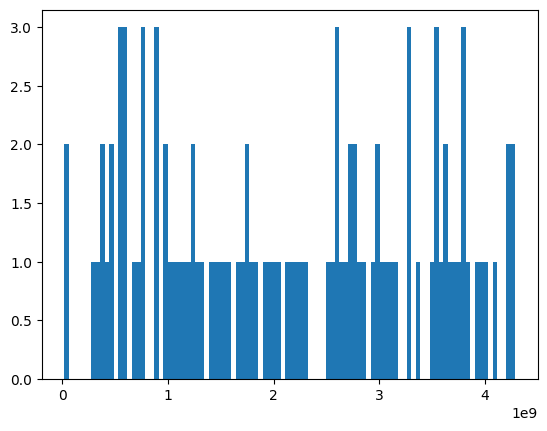

In [83]:
rand_numbers  = get_random_and_plot(generator, 100, 100)


In [86]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

TypeError: 'int' object is not subscriptable

Esto se debe a que no hay grandes diferencias entre los distintos bins. Como se mostro en el grafico anterior.

Sin embargo esto depende enteramente de la suerte que tengamos al generar la muestra, ya que a pesar de que sea poco probable, se podria dar el caso de que los 100 numeros estan en el mismo bin. Por ejemplo en el siguiente caso

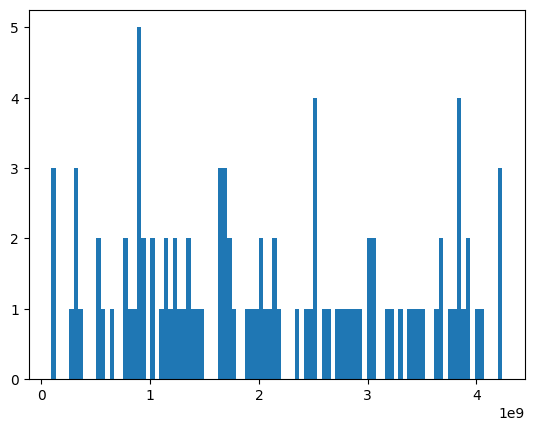

In [20]:
#dejamos pasar 100 numeros de la semilla
for i in range(300):
    generator.rand()

rand_numbers  = get_random_and_plot(generator, 100, 100)



In [21]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 132.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05


En este caso vemos que se rechaza h0, es decir que podemos asegurar bajo un nivel de significancia 0.05 que la distribucion no es de tipo uniforme. Sin embargo esto se debe a que tuvimos "mala suerte" a la hora de obtener los numeros. Lo que se ve en el anterior grafico que contiene muchas mas irregularidades que el anterior

Para evitar que nuestros resultados esten muy influenciados por la "suerte" que tengamos al obtener numeros, los generamos en magnitudes mas grandes, esto hara que sea mucho menos probable que el test de que se rechaza la hipotesis nula por "mala suerte."

Probamos el generador con una muestra de 10000 numeros

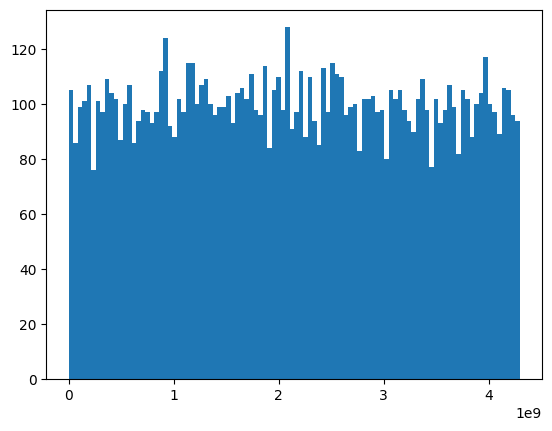

In [22]:
rand_numbers  = get_random_and_plot(generator, 10000, 100)

In [23]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 92.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Probamos el generador con una muestra de 100000 numeros

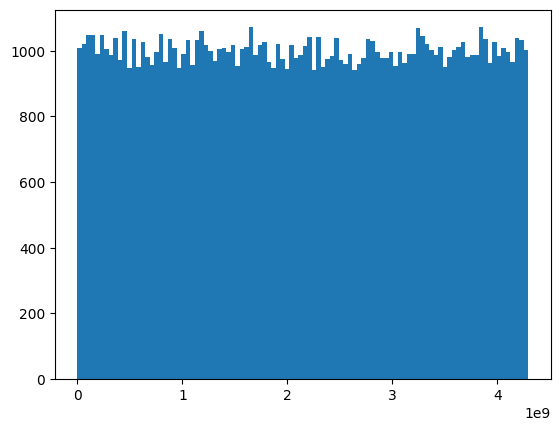

In [24]:
rand_numbers  = get_random_and_plot(generator, 100000, 100)

In [25]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 111.282
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


#### Pruebas para generador normalizado (entre 0 y 1)

A partir de aquí, se prueba el generador para numeros randoms entre 0 y 1, para 100, 10000 y 100000 numeros. Es muy similar a lo obtenido en el caso anterior ya que para generar numeros entre 0 y 1 se utiliza el generador testeado anteriormente.

In [26]:
generator_u = Uniform_generator(653678946)

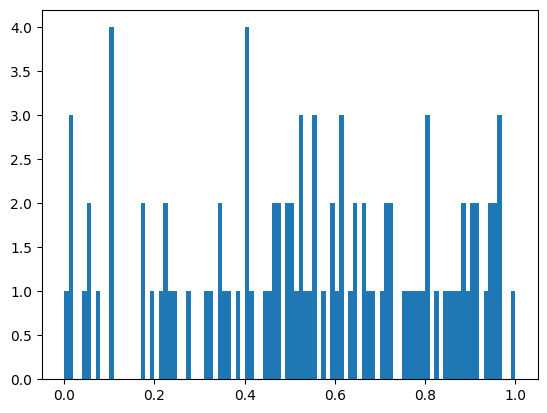

In [27]:
rand_numbers  = get_random_and_plot(generator_u, 100, 100)

In [28]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 94.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


De la misma manera que en el generador anterior, al ser muy pocos los numeros que generamos nuestro test tiene altas chances de dar resultados diferentes segun que tanta "suerte" tengamos al generar los 100 numeros

Probamos el generador con una muestra de 10000 numeros

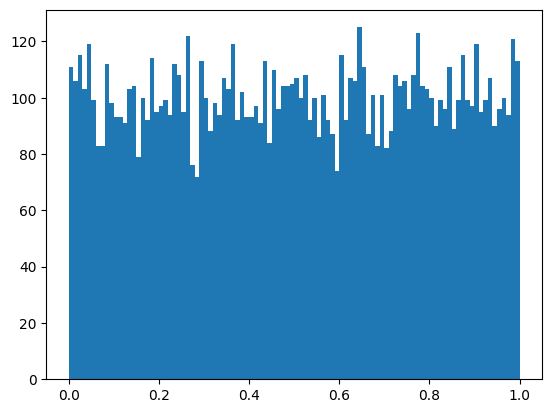

In [29]:
rand_numbers  = get_random_and_plot(generator_u, 10000, 100)

In [30]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 117.52
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Probamos el generador con una muestra de 100000 numeros

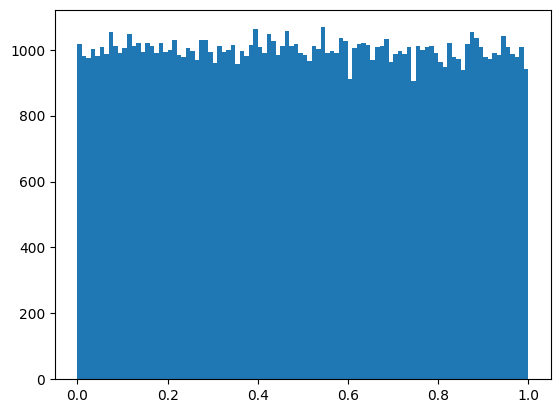

In [31]:
rand_numbers  = get_random_and_plot(generator_u, 100000, 100)

In [32]:
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 81.5
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


### Test Kolmogorov - Smirnov


Referencia: https://www.statology.org/kolmogorov-smirnov-test-python/

**H0** : La distribucion es uniforme(0 y m)  
**H1** : La distribucion **no** es uniforme(0 y m)  

Ya sea continua o discreta la distribucion uniforme

Nuestra hipotesis nula es que el arreglo 'data' (generado por nuestro RNG) sigue una distribucion uniforme.
Si el p-value es menor que el nivel de significacion (por default = 0.05) entonces se rechaza la hipotesis nula y decimos que hay suficiente evidencia para decir que
la muestra de numeros en el arreglo 'data' no viene de una distribucion uniforme.
Empezamos testeando para 100 elementos.

In [33]:
generator = Xorshift_generator(695619357)
generator_u = Uniform_generator(56789876)

In [34]:
def test_kolmogorov_smirnov(distribution, max, quantity, func):
    data = []
    for i in range(quantity):
        data.append(func())
    p_value = kstest(data, distribution, args=(0, max)).pvalue

    if p_value > 0.05:
        print('No hay evidencia para rechazar la hipotesis nula.')
    else:
        print('Rechazamos la hipotesis nula. Los datos no siguen una distribucion uniforme.')
    print(f'El p-valor es: {p_value}')
    plt.hist(data, bins=100)
    plt.show()


No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.5310908217787491


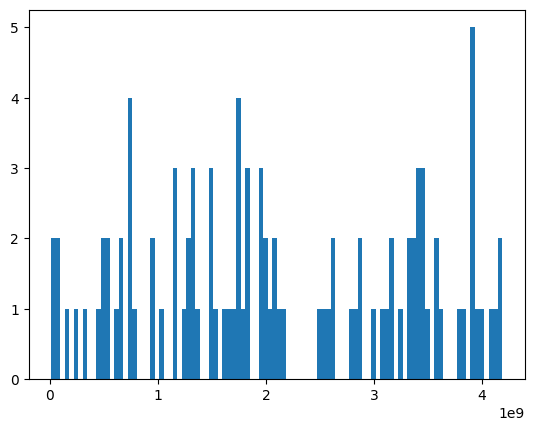

In [35]:
test_kolmogorov_smirnov('randint', (2**32)-1, 100, generator.rand)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.7045294280249534


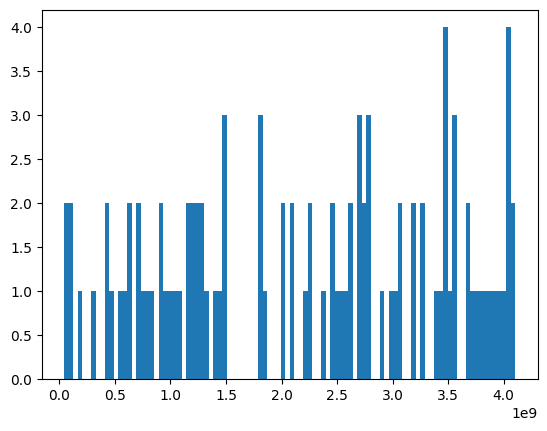

In [36]:
test_kolmogorov_smirnov('randint', (2**32) - 1, 100, generator.rand)

Seguimos con 10000 elementos.

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.9666198078644795


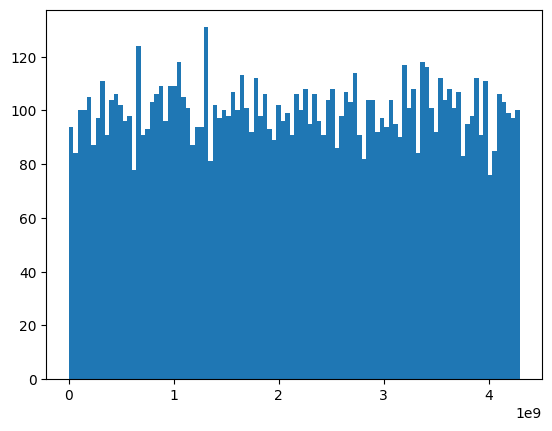

In [37]:
test_kolmogorov_smirnov('randint', (2**32) - 1, 10000, generator.rand)

Finalizamos el testeo con Kolgomorov - Smirnov del RNG con 100000 elementos.

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.9941567430799079


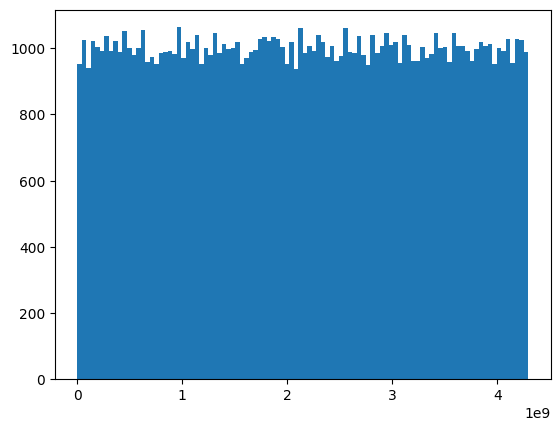

In [38]:
test_kolmogorov_smirnov('randint', (2**32) - 1, 100000, generator.rand)

Ahora testemos con las mismas cantidades de elementos pero para el RNG normalizado. Empezamos con 100 elementos.

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.7767531194346833


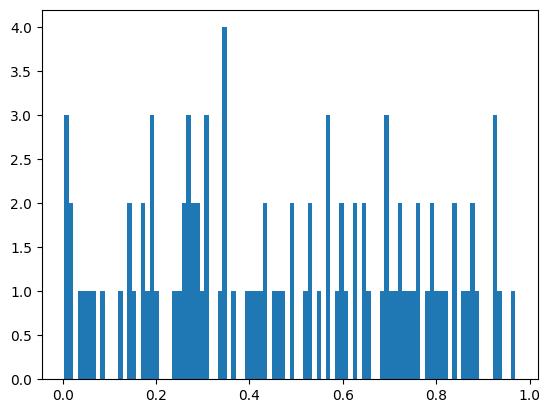

In [39]:
test_kolmogorov_smirnov('uniform', 1, 100, generator_u.rand)

Seguimos con 10000

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.9795675551094133


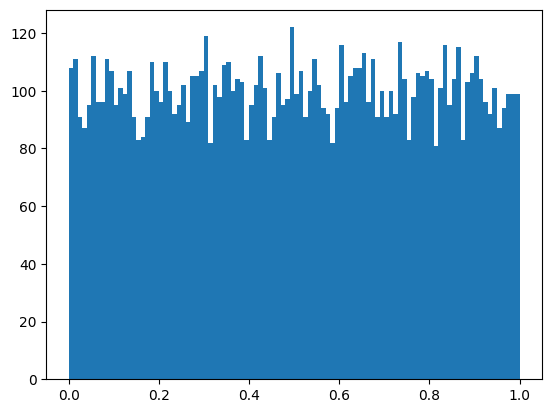

In [40]:
test_kolmogorov_smirnov('uniform', 1, 10000, generator_u.rand)

Finalizamos con 100000

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.9432055354070077


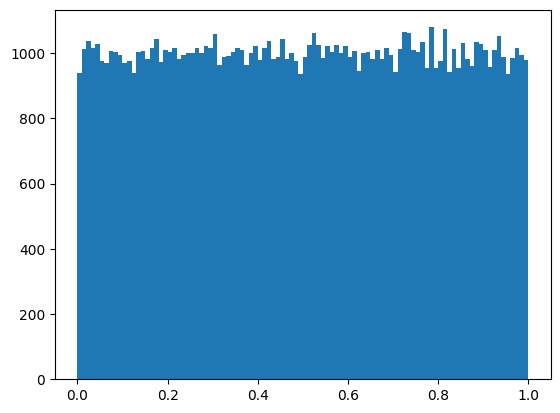

In [41]:
test_kolmogorov_smirnov('uniform', 1, 100000, generator_u.rand)

Despues del análisis de los resultados de los test de _Komolgorov Smirnov_ con las distintas muestras, los resultados tendieron a ser los siguientes:  
  
En la mayoria de las corridas, el test arroja que no tenemos evidencia suficiente para rechazar **H0**, es decir, no hay evidencia para afirmar que la distribucion **no** es uniforme. Esto lo podemos ver también con el resultado del p-valor: el significado que tiene es la probabilidad de cometer un error de tipo 1 (rechazar **H0** cuando es verdadera), cuando el p-valor toma valores muy altos nos indica que hay una probabilidad muy alta de que **H0** sea verdadera si elegimos rechazarla.  
  
Sin embargo, el resultado del test es fluctuante (por ejemplo, en corridas consecutivas los p-valores iban desde cerca de 0.9 a casi 0.01, lo cual nos confundía bastante). Primero creimos que el error estaba en nuestro generador, así que probamos con el generador de numeros aleatorios de python _randint_. Como vimos que también fluctuaba, pensamos que era un error al testear.   
  
Luego de pensarlo y debatirlo, llegamos a una conclusion razonable: El p-valor varía porque la muestra varía (generamos nuevos numeros aleatorios en cada corrida del test), y como el test de hipótesis depende casi exclusivamente de la muestra, eso explica las eventuales variaciones que haya. Que a veces el p-valor sea lo suficientemente chico como para rechazar **H0** nos dice que en esa corrida se genero una muestra que podia contener sesgos y acumulaciones de ciertos numeros en cierto intervalo, lo que hacia que se incline la balanza a favor de decidir que el generador no fuese "uniforme". Este caso puede ocurrir con una probabilidad baja, pero esta no es nula, asi que puede pasar.  

### Test serial

Busca verificar si los numeros de distribuyen uniformemento de o a m, por los uqe podemos plantear.  
**H0** : La distribucion es uniforme(0 y m)  
**H1** : La distribucion **no** es uniforme(0 y m)  

Ya sea continua o discreta la distribucion uniforme


Los pasos para realizar el test serial son:
1. Generar una secuencia de números aleatorios utilizando el generador que se quiere evaluar.
2. Tomar pares de números consecutivos de la secuencia generada.
3. Contar la cantidad de veces que se repite cada combinación de números.
4. Calcular la desviación estándar de la frecuencia de repeticiones de cada combinación.
5. Evaluar si la desviación estándar es mayor que la esperada para una distribución uniforme.

In [8]:
#raiz cuadrada de bin tiene que ser un numero entero
def serial_test(generator, n, bins, max_value, significance_level):
    rand_tuples = []
    for _ in range(n):
        rand_tuples.append((generator.rand(),generator.rand()))

    expected_frequency = len(rand_tuples)/bins

    obs_frequency = get_frequency(rand_tuples, bins, max_value)

    aux = 0
    for i in obs_frequency:
        aux += (i - expected_frequency)**2
    d2 = aux/expected_frequency

    upper_limit = chi2.ppf(1 - significance_level, df=bins-1)

    print(f"D2: {d2}")
    print(f"Valor del cuantil de una Chi-cuadrado de {bins-1} grados de libertad: {upper_limit}")
    if d2 > upper_limit:
        print("Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05")
    else:
        print("No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme")

Podemos pensar en que tenemos un plano de puntos aleatorios, y que los bins ahora son tambien de dos dimensiones, partiendo el plano en igual cantidad de cuadrados, cada uno representando un bin (es por eso que a la cantidad de bins se le debe poder hacer la raiz cuadrada)

In [9]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def get_position_of_one_axis(number, bin_length):
    j = 0
    seguir = True
    while seguir:
        if number < bin_length:
            seguir = False
        else:
            j += 1
            number -= bin_length    
    return j

def get_frequency(rand_tuples, bins, max_value):
    frequency = [[0 for j in range(int(bins**(1/2)))] for i in range(int(bins**(1/2)))]
    bin_length = max_value/(bins)**(1/2)

    for i in rand_tuples:
        bin_x = get_position_of_one_axis(i[0], bin_length)
        bin_y = get_position_of_one_axis(i[1], bin_length)
        frequency[bin_x][bin_y] += 1
    
    return flatten(frequency)

Al igual que antes testeamos ambos generadores, para muestras de 100, 10000, 100000 elementos

In [10]:
generator = Xorshift_generator(int(time.time()) * 8647359734)

In [36]:
serial_test(generator, 100, 100, 2**32 -1, 0.05) # los bins antes estaban en 10000, por eso daba enorme

D2: 100.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


In [40]:
serial_test(generator, 10000, 100, 2**32 -1, 0.05)

D2: 87.7
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


In [41]:
serial_test(generator, 100000, 100, 2**32 -1, 0.05)

D2: 105.186
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


In [51]:
generator_u = Uniform_generator(int(time.time()) * 3476234892)
serial_test(generator_u, 100, 100, 1, 0.05)

D2: 66.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


In [55]:
serial_test(generator_u, 10000, 100, 1, 0.05)

D2: 94.02
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


In [56]:
serial_test(generator_u, 100000, 100, 1, 0.05)

D2: 101.314
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Concluyendo este test, podemos decir que el test serial arrojo buenos resultados al no rechazar la hipótesis nula, esto no afirma que nuestra distribucion es uniforme, sino que no se encontro suficiente evidencia para afirmar con alta probabilidad lo contrario.  
  
Y concluyendo este ejercicio, se ha llevado a cabo un análisis exhaustivo del generador mediante pruebas estadísticas como Chi2, Kolmogorov-Smirnov y Test Serial. Los resultados obtenidos indican que en la mayoría de las ejecuciones, todas estas pruebas han aceptado la hipótesis nula, por lo tanto, se puede concluir que el generador de números aleatorios de 32 bits es confiable y podemos utilizarlo en aquellos escenarios donde necesitemos numeros aleatorios. Por ejemplo, en los ejercicios 4 y 5

## Ejercicio 3

*Utilizando el generador implementado en el ejercicio 1:  
● Implementar un método para generar variables aleatorias con distribución Normal con media 25, y
desvío estándar 3  
● Graficar la distribución que siguen los números pseudoaleatorios generados.  
● Realizar, al menos 2 tests, de los explicados en la materia, para verificar si los números generados siguen la distribución pedida (evalué los resultados para distintos tamaños de muestra).*

Para obtener muestras de una normal, no podemos usar el metodo de la transformada inversa, ya que su funcion de densidad no es invertible. Es por eso que utilizaremos el metodo de aceptacion y rechazo.

Para generar numeros que sigan una distribucion normal vamos a elegir el método de Aceptación y Rechazo 2, partiendo con los numeros producidos por nuestro generador. Lo que vamos a hacer es generamos una distribucion normal estándar, luego podemos pasar de esa normal a una normal con media 25 y desvio estandar 3

Sin embargo, si intentemos usar ya sea el generador de numeros enteros entre 0 hasta 2^32-1 o el generador de numeros uniforme entre 0 y 1, no podremos generar valores que no pertescan al dominio de estos generadores. Es por esto que antes de obtener un generador de valores normales, obtendremos un generador que genere muestras que se distribuyan de manera exponencial, utilizando el metodo de la transformada inversa. 

In [56]:
class Exp_generator:
    def __init__(self, seed, parameter=1):
        self.parameter = parameter
        self.Uniform_generator = Uniform_generator(seed)

    def rand(self):
        r = self.Uniform_generator.rand()
        return log(r/self.parameter)/(-1*self.parameter)
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

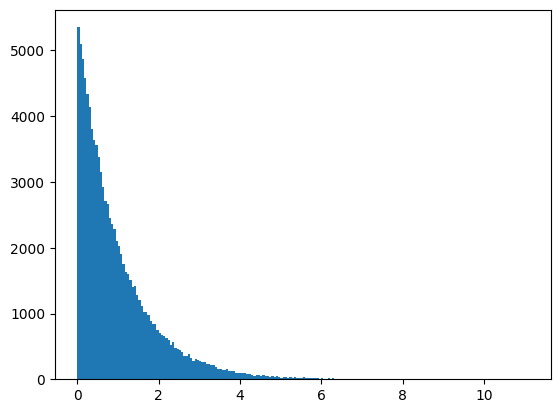

In [57]:
generator_exp = Exp_generator(987654323)
rand_numbers = get_random_and_plot(generator_exp, 100000, 200)

Si bien el dominio de la exponencial es solo do 0 a inf mientras que la normal va de -inf a inf, podemos utilizar un truco, donde generamos la mitad positiva de la campana de Gauss, y luego la multiplicamos por 1 o -1 con probabilidad de 0.5, generando asi toda la campana. Las siguientes funciones de densidad de las variables aleatorias N y X corresponden a las funciones de densidad de una VA Normal estándar y una VA truncada respectivamente

$f_N(n) = \frac{1}{\sqrt{(2*pi)}} * e^{\frac{-n^2}{2}}  $  
$f_X(x) = \frac{2}{\sqrt{(2*pi)}} * e^{\frac{-x^2}{2}} * \mathbf{1} \{ x>0 \}$  

Vamos a generar los numeros de la normal, a partir del generador exponencial, es decir que podemos llamar Y a una VA con distribucion exp, la cual sabemos generar.

In [58]:
def fx_divided_by_fy(x):
    if x < 0:
        return 0
    return (2 / (2 * pi) ** (1 / 2)) * e ** (x -(x ** 2) / 2)

class Normal_distribution_generator:
    
    def __init__(self, seed, mean=0, variance=1):
        self.mean = mean
        self.std_deviation = variance**(1/2)
        self.generator_exp = Exp_generator(seed)
        self.uniform_generator = Uniform_generator(seed + 100) #para que no haya relacion entre los numeros generados entre los generadores usamos semillas distintas
        self.c = fx_divided_by_fy(1) #el maximo se alcanza en 1
        
    def get_parameters(self):
        return self.mean, self.std_deviation

    def rand(self):
        encontrado = False
        while not encontrado:
            r = self.uniform_generator.rand()
            r_exp = self.generator_exp.rand()
            if r < fx_divided_by_fy(r_exp)/self.c:
                encontrado  = r_exp

        r2 = self.uniform_generator.rand()
        
        if r2 < 0.5:
            encontrado = -1 * r_exp
                    
        return self.std_deviation * encontrado + self.mean
    
    def get_n_rand(self, n):
        rand_numbers = []
        for i in range(n):
            rand_numbers.append(self.rand())
        return rand_numbers

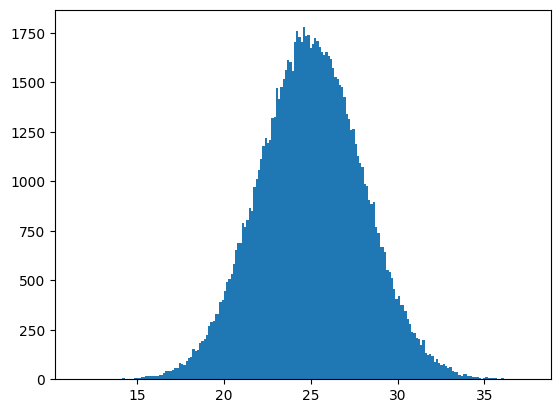

In [59]:
normal_generator = Normal_distribution_generator(987654323, 25, 9)
normal_rand_numbers = get_random_and_plot(normal_generator, 100000, 200)

#### Test Kolmogorov-Smirnov

Para testear la distribucion obtenida a partir del generador unforme, usaremos dos tests estadísticos, uno de ellos será el test de Kolmogorov-Smirnov utilizado en el ejercicio 2.

In [60]:
def kolmogorov_smirnov_normal_test(quantity, normal_generator):
    normal_rand_numbers = []
    for _ in range(quantity):
        normal_rand_numbers.append(normal_generator.rand())
    p_value = kstest(normal_rand_numbers, 'norm', args=normal_generator.get_parameters()).pvalue

    if p_value > 0.05:
        print('No hay evidencia para rechazar la hipotesis nula.')
    else:
        print('Rechazamos la hipotesis nula. Los datos no siguen una distribucion normal.')

    print(f'El p-valor es: {p_value}')

Primero instanciamos el generador de numeros normales

In [61]:
normal_generator = Normal_distribution_generator(5555555)

Luego realizamos el test de Kolmogorov-Smirnov para distintos tamaños de muestras: 100, 10000 y 100000 elementos

In [62]:
kolmogorov_smirnov_normal_test(100, normal_generator)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.6818489915302857


In [63]:
kolmogorov_smirnov_normal_test(10000, normal_generator)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.5340339858566167


In [64]:
kolmogorov_smirnov_normal_test(100000, normal_generator)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.7177487887829975


#### Test Shapiro-Wilk

Ahora realizaremos otro test estadístico, el de Shapiro-Wilk, en donde la hipotesis nula sera que la muestra obtenida por nuestro generador sigue una distribucion normal.

In [65]:
def shapiro_test(quantity):
    data = normal_generator.get_n_rand(quantity)
    
    w, p_value = shapiro(data)

    if p_value > 0.05:
        print('No hay evidencia para rechazar la hipotesis nula.')
    else:
        print('Rechazamos la hipotesis nula. Data no sigue una distribucion uniforme.')
    print(f'El p-valor es: {p_value}')

Procedemos a correr el test con 100, 10000 y 100000 muestras

In [66]:
shapiro_test(100)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.8548449873924255


In [67]:
shapiro_test(10000)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.5852257609367371


/home/diego/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [68]:
shapiro_test(100000)

No hay evidencia para rechazar la hipotesis nula.
El p-valor es: 0.21722063422203064


**Conclusion**  
En todos los casos vemos que no hay evidencia para rechazar la hipotesis nula, por lo que la muestra puede provenir de una distribucion normal. Al igual que para el test de la uniforme, el p-valor va variando según la muestra y vimos que, por ejemplo para el caso de 100 numeros, algunas pocas corridas resultaban en rechazar **H0**, lo cual se explica dado que la cantidad pequeña de muestras puede hacer que el resultado del test fluctue bastante.

## Ejercicio 4

Cargamos el dataset usando pandas, y le agregamos una columna que indica a que cluster pertenece cada punto.

In [58]:
import pandas as pd

In [59]:
clusters = 5
dataset = pd.read_csv('dataset_kmeans_tema2.csv', names=['x', 'y'])
dataset['cluster'] = 0


Para obtener los primero centroides que se van a autilizar en el algoritmo de k-means, definimos un generador uniforme para 'x' y un generador uniforme para 'y'. Ambas variables uniformes estan sobre el intervalo que va desde el menor valor al mayor valor del eje correspondiente. Una vez obtenemos estos generadores podemos generar 5 pares de puntos para asi obtener los 5 centroides. Luego en un proceso iterativo se calcula a que cluster pertenece cada punto del dataset y se recalculan los centroides como la posicion media de los puntos de sus clusters. Se imprime en cada iteracion para ver el progreso del algoritmo y se itera hasta que alguna de las condiciones de corte especificadas por el enunciado se cumpla. 

In [60]:
import time

def finish_kmeans(i, iteration_limitation, centroids_changed, clusters_changed):
    resultado = False
    if i > iteration_limitation:
        print("Se alcanzo el limite de iteraciones")
        resultado = True
    if not centroids_changed:
        print("Los centroides dejaron de cambiar")
        resultado = True
    if not clusters_changed:
        print("Los elementos dejaron de cambiar de cluster")
    return resultado

def kmeans(df,amount_of_clusters, iteration_limitation):
    
    max_x = df['x'].max()
    max_y = df['y'].max()
    min_x = df['x'].min()
    min_y = df['y'].min()

    x_range = max_x - min_x
    y_range = max_y - min_y

    x_generator = Uniform_generator(int(time.time()*123456789 + 57441), x_range, min_x)
    y_generator = Uniform_generator(int(time.time()*987654321) , y_range, min_y)

    centroids = []
    for _ in range(amount_of_clusters):
        centroids.append((x_generator.rand(),y_generator.rand()))

    i = 0
    centroids_changed = True
    clusters_changed = True
    while not finish_kmeans(i, iteration_limitation, centroids_changed, clusters_changed):
        clusters_changed = calculate_clusters(df, centroids)
        print_kmeans(df,centroids)
        centroids, centroids_changed = calculate_new_centroids(df, centroids)
        
        while (len(centroids) < amount_of_clusters ):
            centroids.append((x_generator.rand(),y_generator.rand()))
        i +=1

Cabe aclarar que, en la primera implementacion del algoritmo, si el cluster de un centroide no contenia a ningun punto, ya todos los puntos estaban mas cerca que otro centroide, perdiamos un centroide y el algoritmo se realizaba con menos clusters. Para solucionar esto, en el caso de perder un centroide en una iteracion, lo volvemos a generar de manea aleatoria para mantener la cantidad de clusters.

In [61]:
def euclidean_distance(a, b):
    return ( (a[0]-b[0])**2 + (a[1]-b[1])**2 )**(1/2)

In [62]:
def calculate_clusters(df, centroids):
    clusters_changed = False
    for index, row in df.iterrows():
        point = (row['x'], row['y'])
        distance = []
        for centroid in centroids:
            distance.append(euclidean_distance(point, centroid))
        cluster = distance.index(min(distance))
        if cluster != row['cluster']:
            clusters_changed = True
        df.loc[index, 'cluster'] = cluster
        
    return clusters_changed        

In [63]:
def calculate_new_centroids(df, last_centroids):
    centroids_changed = False
    agrupado = df.groupby('cluster').mean()
    centroids = []
    for index, row in agrupado.iterrows():
        if last_centroids[index] != (row['x'], row['y']):
            centroids_changed = True
        centroids.append((row['x'], row['y']))

    return centroids, centroids_changed
            

In [64]:
def print_kmeans(df, centroids):
    
    colors = dataset['cluster'].values.tolist()
    centroids_x = []
    centroids_y = []
    for centroid in centroids:
        centroids_x.append(centroid[0])
        centroids_y.append(centroid[1])

    plt.scatter(df.loc[:,'x'], df.loc[:,'y'], c = colors , s=2, cmap= 'viridis')
    plt.scatter(centroids_x, centroids_y, s=200, alpha=1, c ="red")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

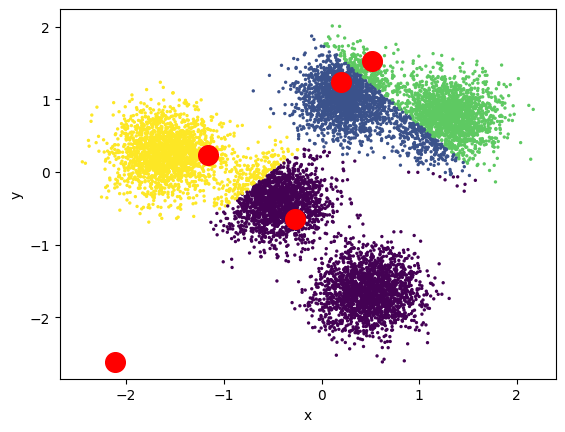

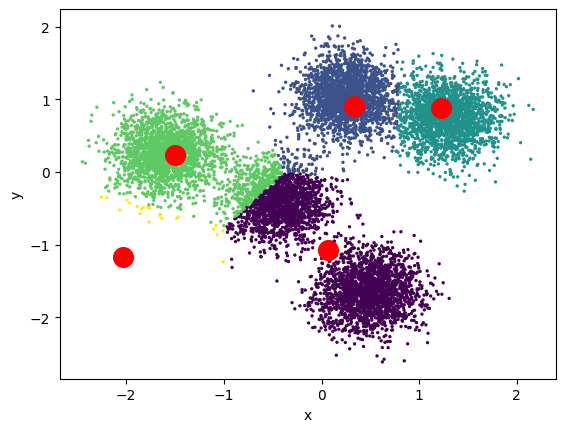

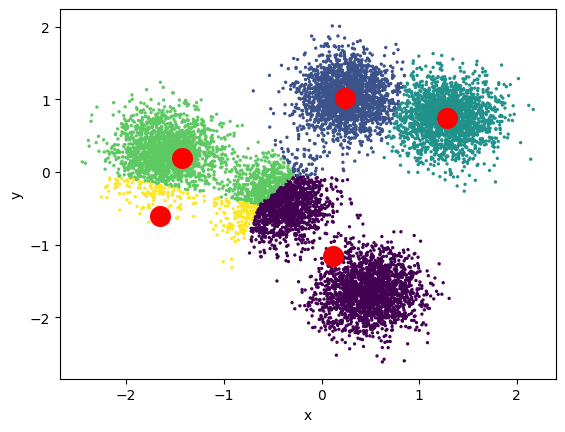

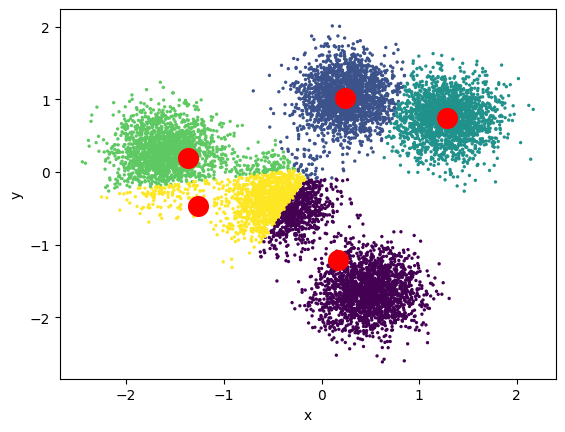

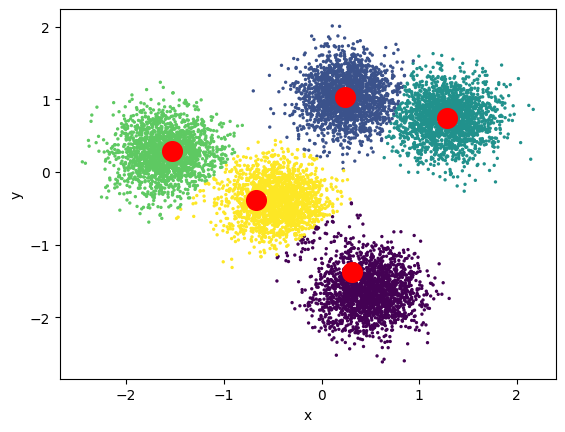

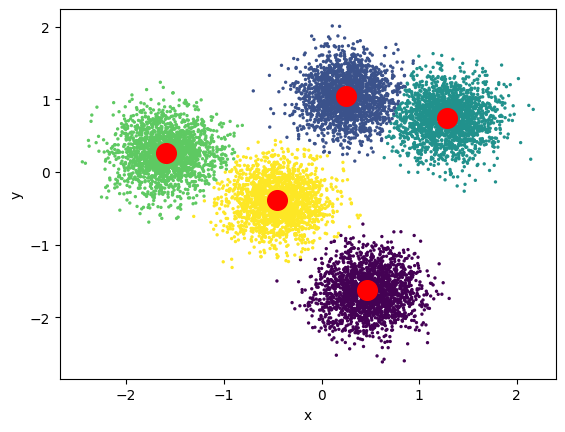

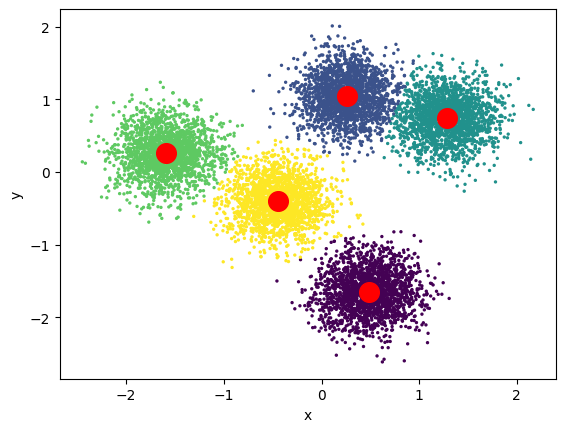

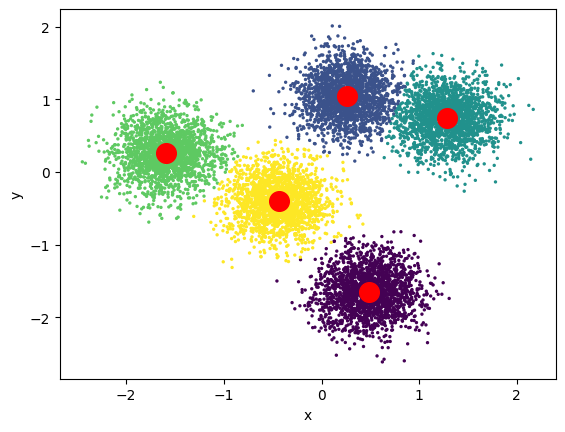

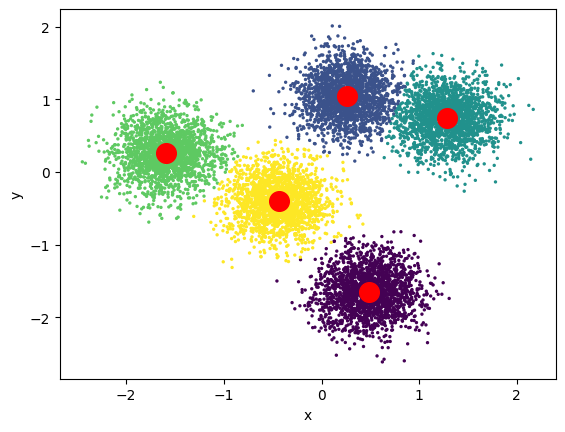

Los centroides dejaron de cambiar
Los elementos dejaron de cambiar de cluster


In [67]:
kmeans(dataset, 5, 10)

Cabe destacar que KMeans no es determinístico: no nos va a dar siempre el mismo resultado ya que los centroides se generan de forma aleatoria. Si ejecutamos el algoritmo varias veces con el mismo conjunto de datos y el mismo número de clusters, los resultados suelen ser similares. Por lo tanto, aunque la asignación de puntos a grupos puede variar de una ejecución a otra, en general las agrupaciones resultantes son representativas de los datos analizados. De todos modos, se puede ver que este dataset tiene una estructura que favorece a la consistencia de KMeans.

## Ejercicio 5

### Targets over globe

In [68]:
import geopandas as gpd
import matplotlib.pyplot as plt

df = gpd.read_file('WB_Coastlines_10m.shp')



Para obtener los puntos aleatorios sobre el area que conforma el rectandulo de vertices [−60◦,60◦] [−150◦, 150◦], hacemos algo muy similar a lo hecho para obtener los puntos aleatorios del algoritmo de k-means. Definimos dos variables uniformes que van del minimo al maximo de cada eje, y luego para obtener un punto aleatorio sobre el mapa generamos un valor de cada una

In [69]:
def targets_over_globe(amount_of_targets):
    max_x = 150
    max_y = 60
    min_x = -150
    min_y = -60

    x_range = max_x - min_x
    y_range = max_y - min_y

    x_generator = Uniform_generator(int(time.time()*123456789), x_range, min_x)
    y_generator = Uniform_generator(int(time.time()*987654321) , y_range, min_y)

    points = []
    for _ in range(amount_of_targets):
        points.append((x_generator.rand(),y_generator.rand()))
    return points

In [70]:
points = targets_over_globe(5000)

Graficamos los resultados

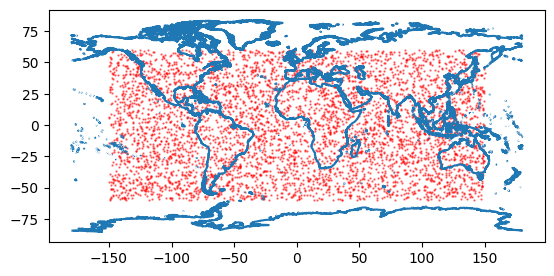

In [71]:
df.plot()
points_x = []
points_y = []
for point in points:
    points_x.append(point[0])
    points_y.append(point[1])
plt.scatter(points_x, points_y, s=0.5, alpha=0.5, c="red")
plt.show()

### Targets over Greenland

Obtenemos el mapa de Groenladia

In [72]:
from shapely.geometry import Point, LineString, Polygon

greenland = df.iloc[[513, 514]]

linea1 = greenland.loc[513,'geometry']
linea2 = greenland.loc[514,'geometry']
greenland_poly = Polygon(list(linea1.coords) + list(linea2.coords[1:]))

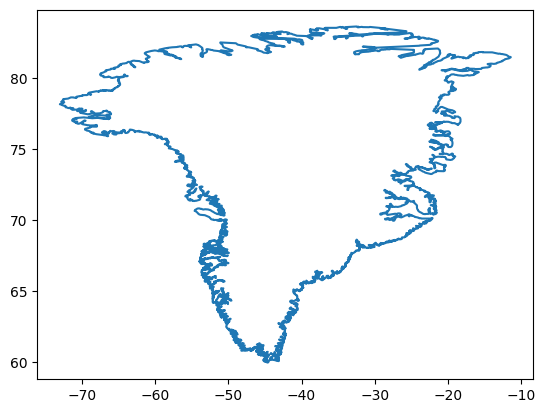

In [73]:
poly_x, poly_y = greenland_poly.exterior.xy
plt.plot(poly_x, poly_y)

Para obtener un generador que genere muestras uniformes sobre Groenlandia, debido a su forma compleja, usamos el metodo de aceptacion rechazo. Para esto tomamos un cuadrado que recubre a groenlandia, y de la misma forma que se hizo en el inciso anterior se genera un punto aleatorio que pertenesca al cuadrado. Si ese punto pertenece a groenlandia entonces lo aceptamos, de lo contrario lo rechazamos. Para que se acepten la mayor cantidad de numeros sin complejizar la forma geometrica, tomamos el minimo rectangulo que recubre a Groenlandia.

In [74]:
minimal_square = greenland_poly.envelope

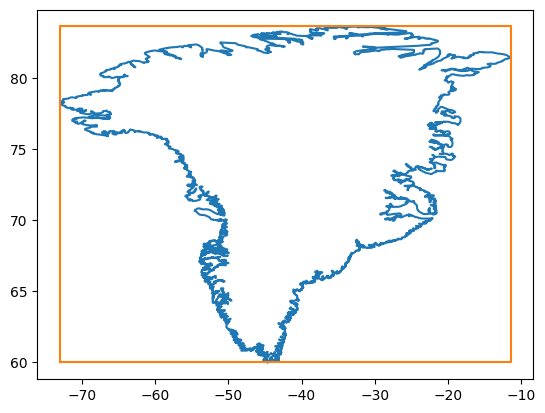

In [75]:
square_x, square_y = minimal_square.exterior.xy
plt.plot(poly_x, poly_y)
plt.plot(square_x, square_y)
plt.show()

El siguiente codigo intenta generar tantos puntos como se le indique, rechazando aquellos que no esten incluidos en Groenlandia

In [76]:
def target_over_greenland(amount_of_targets):
    minimal_square_x, minimal_square_y = minimal_square.exterior.coords.xy
    max_x = max(list(minimal_square_x))
    max_y = max(list(minimal_square_y))
    min_x = min(list(minimal_square_x))
    min_y = min(list(minimal_square_y))

    x_range = max_x - min_x
    y_range = max_y - min_y

    x_generator = Uniform_generator(int(time.time()*123456789), x_range, min_x)
    y_generator = Uniform_generator(int(time.time()*987654321) , y_range, min_y)

    points = []
    rejected_points = []
    for _ in range(amount_of_targets):
        point = Point(x_generator.rand(),y_generator.rand())
        if greenland_poly.contains(point):
            points.append((point.x,point.y))
        else:
            rejected_points.append((point.x,point.y))
    return points, rejected_points

Intentamos obtener 5000 targets

In [77]:
greenland_targets_quant = 5000
greenland_points, rejected_points = target_over_greenland(greenland_targets_quant)

Graficamos los puntos aceptados

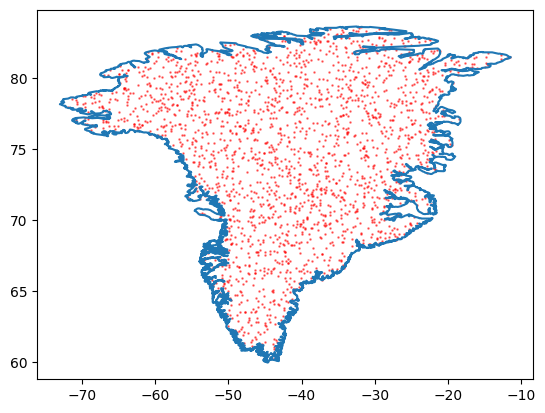

In [79]:
plt.plot(poly_x, poly_y)
points_x = []
points_y = []
for point in greenland_points:
    points_x.append(point[0])
    points_y.append(point[1])
plt.scatter(points_x, points_y, s=0.7, alpha=0.5, c="red")
plt.show()

Graficamos los puntos rechazados

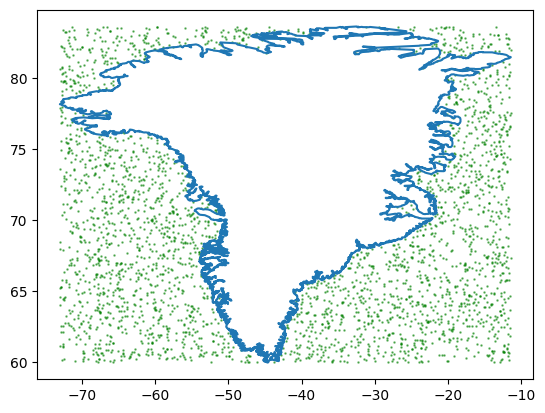

In [80]:
plt.plot(poly_x, poly_y)
points_x = []
points_y = []
for point in rejected_points:
    points_x.append(point[0])
    points_y.append(point[1])
plt.scatter(points_x, points_y, s=0.7, alpha=0.5, c="green")
plt.show()

El factor de rendimineto empirico se obtiene tras dividir los puntos aceptados por los puntos totales, que resulto en:

In [81]:
print(f'Factor de rendimiento: {len(greenland_points)} / {greenland_targets_quant} = {len(greenland_points)/greenland_targets_quant}')

Factor de rendimiento: 2133 / 5000 = 0.4266
